In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation


In [2]:
df = pd.read_csv(r'C:\Users\Darshan\Downloads\train.csv (1)\train.csv')# skiprows=[54475], nrows=10)
df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [3]:
df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [5]:
df['date'] = pd.to_datetime(df['date'], format= "%Y/%m/%d")

In [6]:
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])

In [7]:
agg_df

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.000000
33,2013-01-02,AUTOMOTIVE,255.000000
66,2013-01-03,AUTOMOTIVE,161.000000
99,2013-01-04,AUTOMOTIVE,169.000000
132,2013-01-05,AUTOMOTIVE,342.000000
...,...,...,...
55439,2017-08-11,SEAFOOD,1272.615997
55472,2017-08-12,SEAFOOD,1028.030006
55505,2017-08-13,SEAFOOD,1118.047000
55538,2017-08-14,SEAFOOD,970.679999


In [8]:
total_sales_df = agg_df.pivot(index='date',columns='family', values='sales')
total_sales_df.head(10)

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,2.0,810.0,0.0,180.58900,0.0,186.0,143.0,71.09000,...,0.0,110.801000,25.0,0.0,0.0,42.637000,37.847000,0.0,0.0,0.000000
2013-01-02,255.0,0.0,207.0,72092.0,0.0,26246.31900,0.0,74629.0,23381.0,15754.50000,...,0.0,20871.464028,17204.0,0.0,0.0,13975.884938,5338.111976,0.0,0.0,1526.750002
2013-01-03,161.0,0.0,125.0,52105.0,0.0,18456.48002,0.0,55893.0,18001.0,11172.45500,...,0.0,16597.398113,12568.0,0.0,0.0,10674.393983,3591.388005,0.0,0.0,1094.310994
2013-01-04,169.0,0.0,133.0,54167.0,0.0,16721.96901,0.0,52064.0,18148.0,10143.20900,...,0.0,21625.963055,11303.0,0.0,0.0,10772.515038,4472.965990,0.0,0.0,1293.120995
2013-01-05,342.0,0.0,191.0,77818.0,0.0,22367.76108,0.0,70128.0,23082.0,13734.94501,...,0.0,20879.091050,16819.0,0.0,0.0,13475.009055,5830.073020,0.0,0.0,1245.637004
2013-01-06,360.0,0.0,265.0,86184.0,0.0,26861.66500,0.0,74295.0,23660.0,16229.26000,...,0.0,21880.005115,19665.0,0.0,0.0,15921.096981,6233.714990,0.0,0.0,1443.776992
2013-01-07,189.0,0.0,124.0,51619.0,0.0,17646.15100,0.0,50036.0,15839.0,9647.73900,...,0.0,18314.175078,11205.0,0.0,0.0,10086.555999,3638.761990,0.0,0.0,947.795999
2013-01-08,229.0,0.0,116.0,46941.0,0.0,15805.76402,0.0,45075.0,14532.0,8269.91600,...,0.0,16200.319985,12109.0,0.0,0.0,8724.139959,3555.970020,0.0,0.0,1038.922001
2013-01-09,164.0,0.0,104.0,47910.0,0.0,16002.83002,0.0,42958.0,16250.0,7817.08500,...,0.0,19139.782952,9489.0,0.0,0.0,8488.299022,3994.900002,0.0,0.0,988.307997


In [9]:
total_sales_df = total_sales_df[total_sales_df.index>='2015-08-15']

In [10]:
total_sales_df

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2015-08-15,454.0,18.0,251.0,217135.0,0.0,32509.90608,1157.0,75837.0,48578.0,19946.925000,...,153.0,20403.940990,19398.0,370.0,1250.0,24718.795975,6854.544020,128147.17800,701.0,1507.242994
2015-08-16,413.0,11.0,313.0,208213.0,0.0,34851.87800,724.0,75824.0,50930.0,21178.461000,...,157.0,20616.159980,21048.0,359.0,913.0,25480.778935,6640.393014,131493.92710,793.0,1448.716997
2015-08-17,289.0,14.0,175.0,149741.0,0.0,26361.76895,593.0,59718.0,38358.0,15755.025000,...,125.0,16725.028985,14854.0,263.0,593.0,18549.113000,5212.498015,102769.59890,458.0,1166.222013
2015-08-18,295.0,10.0,166.0,132609.0,0.0,23915.94802,709.0,52749.0,33273.0,14119.251000,...,102.0,15377.124025,13064.0,193.0,519.0,15722.331040,4758.126975,106468.22500,494.0,951.633993
2015-08-19,314.0,5.0,176.0,131368.0,0.0,23995.15200,599.0,51157.0,35760.0,13250.039000,...,102.0,15654.345964,12581.0,257.0,535.0,16360.620083,5275.078985,132449.57997,545.0,996.733998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,441.0,7.0,351.0,189111.0,0.0,28204.48600,870.0,55682.0,44909.0,18680.488004,...,500.0,26944.092010,15978.0,587.0,654.0,25318.297990,5199.494021,118738.14300,3523.0,1272.615997
2017-08-12,403.0,3.0,369.0,182318.0,0.0,27403.54800,849.0,57935.0,42854.0,15689.893010,...,483.0,17775.650112,15903.0,508.0,712.0,19134.510058,4573.465992,111788.35090,3644.0,1028.030006
2017-08-13,481.0,9.0,433.0,202354.0,1.0,33262.75700,544.0,61757.0,50112.0,17593.274020,...,469.0,18633.015039,18188.0,541.0,741.0,20509.265004,4941.509018,125923.80240,3718.0,1118.047000


In [11]:
#setting variables
feature = 'PRODUCE'
prediction_days = 365

In [12]:
df = total_sales_df[[feature]].reset_index()
df.tail()

family,date,PRODUCE
725,2017-08-11,118738.14300
726,2017-08-12,111788.35090
727,2017-08-13,125923.80240
728,2017-08-14,115257.59598
729,2017-08-15,125108.97100


In [13]:
#adding holiday data

holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()  # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict


for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

,ds,holiday,lower_window,upper_window
0,2015-01-01,EC-Holidays,-2,1
1,2015-02-16,EC-Holidays,-2,1
2,2015-02-17,EC-Holidays,-2,1
3,2015-04-03,EC-Holidays,-2,1
4,2015-05-01,EC-Holidays,-2,1


In [14]:
#Variables

forecast_start_dt = date(2017,7,1) #data set ends of (2017,8,15)
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d") 
print(forecast_start_date)

2017-07-01


In [15]:
#PROPHET MODEL

df_copy = df.copy()
df_copy = df_copy.rename(columns={'date': 'ds', feature: 'y'})
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

df_copy['ds'] = pd.to_datetime(df_copy['ds'])

train_set = df_copy[(df_copy['ds'] < forecast_start_date) ]

m = Prophet()

m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

17:12:14 - cmdstanpy - INFO - Chain [1] start processing
17:12:14 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
predicted_df.tail()

,ds,yhat
1044,2018-06-26,140605.429388
1045,2018-06-27,173214.395637
1046,2018-06-28,115631.755419
1047,2018-06-29,128980.454213
1048,2018-06-30,157828.529930


In [17]:
df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)

In [18]:
predicted_df

,ds,yhat,ytrue
0,2017-07-01,144618.473423,155487.63090
1,2017-07-02,155341.685734,172890.13860
2,2017-07-03,122390.829532,130389.19902
3,2017-07-04,127649.412428,131534.54802
4,2017-07-05,160258.378678,163804.33003
5,2017-07-06,102675.738460,99395.60498
6,2017-07-07,116024.437254,114346.57410
7,2017-07-08,144872.512971,139294.77300
8,2017-07-09,155595.725283,156633.92050
9,2017-07-10,122644.869081,118856.99105


In [19]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100
mape(predicted_df['ytrue'], predicted_df['yhat'])

7.549488963477296

In [20]:
m = Prophet()
m.fit(train_set)
df_cv = cross_validation(m, initial='365 days', period='365 days', horizon = '30 days')

17:12:15 - cmdstanpy - INFO - Chain [1] start processing
17:12:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

17:12:16 - cmdstanpy - INFO - Chain [1] start processing
17:12:16 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,3.367311e+07,5802.853699,5458.008076,0.043516,0.032542,0.044618,1.000000
1,4 days,2.428540e+08,15583.773145,12737.848685,0.079456,0.065852,0.083910,0.666667
2,5 days,2.208025e+08,14859.425073,10068.544511,0.057851,0.032153,0.061557,0.666667
3,6 days,2.132284e+08,14602.341064,8635.168810,0.048424,0.003873,0.051953,0.666667
4,7 days,9.113093e+06,3018.790051,1940.857017,0.012132,0.003873,0.012298,1.000000
5,8 days,4.666312e+07,6831.040573,5436.796793,0.050168,0.031488,0.048244,1.000000
6,9 days,4.908396e+07,7005.994455,6185.946288,0.056960,0.031488,0.054942,1.000000
7,10 days,7.893433e+07,8884.499360,8051.174580,0.073377,0.080738,0.070146,1.000000
8,11 days,8.256010e+07,9086.258974,8218.034550,0.057276,0.066840,0.056905,1.000000
9,12 days,1.040334e+08,10199.675778,10131.826695,0.073952,0.074278,0.072791,1.000000


In [22]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,3.367311e+07,5802.853699,5458.008076,0.043516,0.032542,0.044618,1.000000
1,4 days,2.428540e+08,15583.773145,12737.848685,0.079456,0.065852,0.083910,0.666667
2,5 days,2.208025e+08,14859.425073,10068.544511,0.057851,0.032153,0.061557,0.666667
3,6 days,2.132284e+08,14602.341064,8635.168810,0.048424,0.003873,0.051953,0.666667
4,7 days,9.113093e+06,3018.790051,1940.857017,0.012132,0.003873,0.012298,1.000000


In [23]:
df_cv['mape'] = (df_cv['y']-df_cv['yhat'])/(df_cv['y'])*100
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y'] 

df_cv.sort_values('mape',ascending=False).head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
3,2017-06-04,154866.723732,135367.634819,173815.373122,180153.61750,2017-05-31,14.036295,False
16,2017-06-17,144873.296964,125573.873655,164181.266988,165171.25490,2017-05-31,12.289038,False
10,2017-06-11,155178.970431,137196.421169,173701.090330,166293.97900,2017-05-31,6.683951,False
1,2017-06-02,115392.246147,97196.061567,134094.815638,123526.76800,2017-05-31,6.585230,False
15,2017-06-16,116016.739545,97354.516351,135337.489388,124173.95350,2017-05-31,6.569183,False
0,2017-06-01,102487.907959,82385.896856,122912.836733,105935.27990,2017-05-31,3.254225,False
2,2017-06-03,144248.803567,126016.628074,163945.121886,149040.93400,2017-05-31,3.215312,False
6,2017-06-07,160064.464680,141295.866984,179394.250453,165268.42307,2017-05-31,3.148792,False
19,2017-06-20,128146.118708,107655.144521,146663.760653,129791.26500,2017-05-31,1.267532,False
24,2017-06-25,155803.463828,135608.440664,176045.235229,155953.90880,2017-05-31,0.096468,False


In [24]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
0,2017-06-01,102487.907959,82385.896856,122912.836733,105935.27990,2017-05-31,3.254225,False
1,2017-06-02,115392.246147,97196.061567,134094.815638,123526.76800,2017-05-31,6.585230,False
2,2017-06-03,144248.803567,126016.628074,163945.121886,149040.93400,2017-05-31,3.215312,False
3,2017-06-04,154866.723732,135367.634819,173815.373122,180153.61750,2017-05-31,14.036295,False
4,2017-06-05,122345.350431,103117.764100,141061.938366,122218.74110,2017-05-31,-0.103592,True
5,2017-06-06,127521.625310,107582.394814,147097.309157,127029.62198,2017-05-31,-0.387314,True
6,2017-06-07,160064.464680,141295.866984,179394.250453,165268.42307,2017-05-31,3.148792,False
7,2017-06-08,102800.154658,82726.666572,121489.579531,92185.72600,2017-05-31,-11.514178,True
8,2017-06-09,115704.492846,96236.146493,135783.908651,112965.04103,2017-05-31,-2.425044,True
9,2017-06-10,144561.050265,125965.054290,165160.328377,133761.40700,2017-05-31,-8.073811,True


In [25]:
import itertools 

In [26]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = [] 

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_set)  # Fit model with given params
    df_cv = cross_validation(m, initial='365 days', period='365 days', horizon = '30 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

17:12:17 - cmdstanpy - INFO - Chain [1] start processing
17:12:17 - cmdstanpy - INFO - Chain [1] done processing
17:12:23 - cmdstanpy - INFO - Chain [1] start processing
17:12:23 - cmdstanpy - INFO - Chain [1] done processing
17:12:29 - cmdstanpy - INFO - Chain [1] start processing
17:12:29 - cmdstanpy - INFO - Chain [1] done processing
17:12:36 - cmdstanpy - INFO - Chain [1] start processing
17:12:36 - cmdstanpy - INFO - Chain [1] done processing
17:12:43 - cmdstanpy - INFO - Chain [1] start processing
17:12:43 - cmdstanpy - INFO - Chain [1] done processing
17:12:48 - cmdstanpy - INFO - Chain [1] start processing
17:12:48 - cmdstanpy - INFO - Chain [1] done processing
17:12:53 - cmdstanpy - INFO - Chain [1] start processing
17:12:54 - cmdstanpy - INFO - Chain [1] done processing
17:12:59 - cmdstanpy - INFO - Chain [1] start processing
17:12:59 - cmdstanpy - INFO - Chain [1] done processing
17:13:04 - cmdstanpy - INFO - Chain [1] start processing
17:13:04 - cmdstanpy - INFO - Chain [1]

In [27]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  11223.660488
1                     0.001                     0.10  10051.695911
2                     0.001                     1.00  10001.383810
3                     0.001                    10.00  10073.108806
4                     0.010                     0.01  11088.620468
5                     0.010                     0.10   9851.006910
6                     0.010                     1.00   9901.649020
7                     0.010                    10.00   9876.891395
8                     0.100                     0.01  10503.011428
9                     0.100                     0.10   9475.304374
10                    0.100                     1.00   9439.430022
11                    0.100                    10.00   9437.795892
12                    0.500                     0.01  11664.254176
13                    0.500                     0.10  10754.29

In [28]:
tuning_results.sort_values('rmse')

,changepoint_prior_scale,seasonality_prior_scale,rmse
11,0.100,10.00,9437.795892
10,0.100,1.00,9439.430022
9,0.100,0.10,9475.304374
5,0.010,0.10,9851.006910
7,0.010,10.00,9876.891395
6,0.010,1.00,9901.649020
2,0.001,1.00,10001.383810
1,0.001,0.10,10051.695911
3,0.001,10.00,10073.108806
8,0.100,0.01,10503.011428


In [29]:
tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0]

changepoint_prior_scale       0.100000
seasonality_prior_scale      10.000000
rmse                       9437.795892
Name: 0, dtype: float64

In [30]:
dict(tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0])

{'changepoint_prior_scale': 0.1,
 'seasonality_prior_scale': 10.0,
 'rmse': 9437.795891880789}

In [31]:
params_dictionary = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse',axis='columns').iloc[0])

m = Prophet(changepoint_prior_scale = params_dictionary['changepoint_prior_scale'], 
            seasonality_prior_scale = params_dictionary['seasonality_prior_scale'])

In [32]:
m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)
mape(predicted_df['ytrue'], predicted_df['yhat'])

17:13:49 - cmdstanpy - INFO - Chain [1] start processing
17:13:49 - cmdstanpy - INFO - Chain [1] done processing


5.996186924609058

C:\Users\Darshan\AppData\Local\Temp\ipykernel_12132\744206666.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecasted_df.append(forecasted_df)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
684,2017-07-01,130250.652386,123910.816954,160765.323371,130250.652386,130250.652386,12014.926506,12014.926506,12014.926506,12014.926506,12014.926506,12014.926506,0.0,0.0,0.0,142265.578892
685,2017-07-02,130255.931194,133283.667150,171662.417385,130255.931194,130255.931194,22722.018498,22722.018498,22722.018498,22722.018498,22722.018498,22722.018498,0.0,0.0,0.0,152977.949693
686,2017-07-03,130261.210003,101006.342860,138524.815164,130261.210003,130261.210003,-10288.031176,-10288.031176,-10288.031176,-10288.031176,-10288.031176,-10288.031176,0.0,0.0,0.0,119973.178827
687,2017-07-04,130266.488811,105715.549263,143660.175612,130266.488811,130266.488811,-5065.657713,-5065.657713,-5065.657713,-5065.657713,-5065.657713,-5065.657713,0.0,0.0,0.0,125200.831098
688,2017-07-05,130271.767620,139347.856298,175400.596408,130271.767620,130271.767620,27509.739928,27509.739928,27509.739928,27509.739928,27509.739928,27509.739928,0.0,0.0,0.0,157781.507548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,2018-06-26,132151.023454,99346.253602,156642.249700,109849.190118,154221.387522,-5065.657713,-5065.657713,-5065.657713,-5065.657713,-5065.657713,-5065.657713,0.0,0.0,0.0,127085.365741
1045,2018-06-27,132156.302263,129357.661522,189485.484436,109737.227515,154317.332889,27509.739928,27509.739928,27509.739928,27509.739928,27509.739928,27509.739928,0.0,0.0,0.0,159666.042191
1046,2018-06-28,132161.581071,71724.188717,130828.506174,109633.962237,154429.061484,-30115.756857,-30115.756857,-30115.756857,-30115.756857,-30115.756857,-30115.756857,0.0,0.0,0.0,102045.824214
1047,2018-06-29,132166.859880,84226.082307,144738.891710,109525.435943,154538.948798,-16777.239185,-16777.239185,-16777.239185,-16777.239185,-16777.239185,-16777.239185,0.0,0.0,0.0,115389.620695


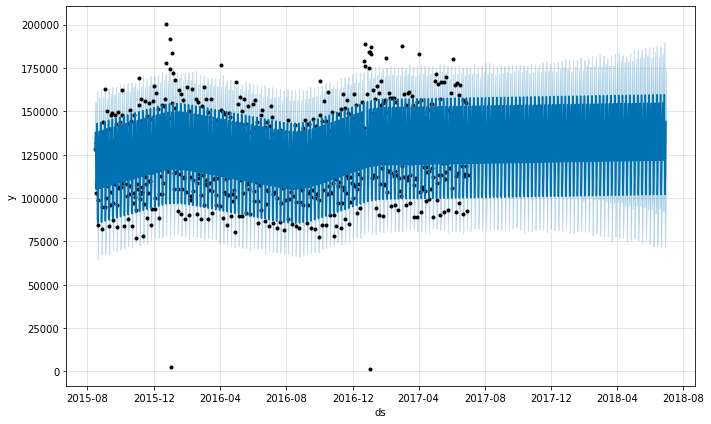

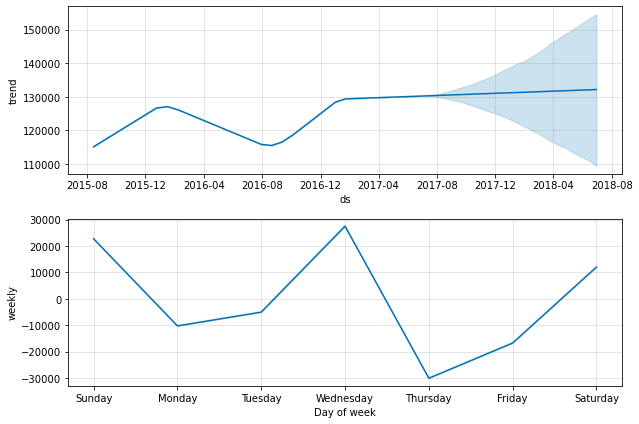

In [33]:
future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)
    
fig1 = m.plot(fcst_prophet_train)
fig2 = m.plot_components(fcst_prophet_train)

forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    
forecasted_df.append(forecasted_df)

95.162558287385221

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

In [35]:
df.set_index('date', inplace=True)

In [36]:
ts = df[feature]
ts

date
2015-08-15    128147.17800
2015-08-16    131493.92710
2015-08-17    102769.59890
2015-08-18    106468.22500
2015-08-19    132449.57997
                  ...     
2017-08-11    118738.14300
2017-08-12    111788.35090
2017-08-13    125923.80240
2017-08-14    115257.59598
2017-08-15    125108.97100
Name: PRODUCE, Length: 730, dtype: float64

In [46]:
from math import sqrt
from itertools import product

In [47]:
# Define the hyperparameter grid for ARIMA
p_values = range(0, 6)  # Adjust as needed
d_values = range(1, 2)  # Assuming 1 for differencing
q_values = range(0, 2)  # Adjust as needed

# Perform grid search for ARIMA
best_arima_params = None
best_arima_rmse = float('inf')

for p, d, q in product(p_values, d_values, q_values):
    arima_model = sm.tsa.ARIMA(train, order=(p, d, q))
    arima_fit = arima_model.fit()
    
    arima_pred = arima_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
    
    rmse_arima = sqrt(mean_squared_error(test, arima_pred))
    
    if rmse_arima < best_arima_rmse:
        best_arima_rmse = rmse_arima
        best_arima_params = (p, d, q)

print(f'Best ARIMA hyperparameters: {best_arima_params}')
print(f'Best ARIMA RMSE: {best_arima_rmse:.2f}')

# Define the hyperparameter grid for SARIMA
P_values = range(0, 2)  # Adjust as needed
D_values = range(1, 2)  # Assuming 1 for seasonal differencing
Q_values = range(0, 2)  # Adjust as needed
s_values = [12]  # Assuming seasonality of 12 months

# Perform grid search for SARIMA
best_sarima_params = None
best_sarima_rmse = float('inf')

for P, D, Q, s in product(P_values, D_values, Q_values, s_values):
    sarima_model = SARIMAX(train, order=(best_arima_params[0], best_arima_params[1], best_arima_params[2]),
                           seasonal_order=(P, D, Q, s))
    sarima_fit = sarima_model.fit()
    
    sarima_pred = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
    
    rmse_sarima = sqrt(mean_squared_error(test, sarima_pred))
    
    if rmse_sarima < best_sarima_rmse:
        best_sarima_rmse = rmse_sarima
        best_sarima_params = (P, D, Q, s)

print(f'Best SARIMA hyperparameters: {best_sarima_params}')
print(f'Best SARIMA RMSE: {best_sarima_rmse:.2f}')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\P

Best ARIMA hyperparameters: (5, 1, 1)
Best ARIMA RMSE: 22865.23


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\Anaco

Best SARIMA hyperparameters: (0, 1, 1, 12)
Best SARIMA RMSE: 28447.84


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [48]:
# Train-test split
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

In [49]:
test

date
2017-03-23     89006.72801
2017-03-24    107276.97280
2017-03-25    136181.70500
2017-03-26    149023.55190
2017-03-27    110965.71600
                  ...     
2017-08-11    118738.14300
2017-08-12    111788.35090
2017-08-13    125923.80240
2017-08-14    115257.59598
2017-08-15    125108.97100
Name: PRODUCE, Length: 146, dtype: float64

In [58]:
# ARIMA model
order = (5, 1, 5)  # p is the order of the autoregressive (AR) part,d is the order of differencing,q is the order of the moving average (MA) part.
arima_model = sm.tsa.ARIMA(train, order=order)
arima_fit = arima_model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [60]:
# SARIMA model
order_sarima = (1, 1, 1, 12)  #p is the order of the autoregressive (AR) part,d is the order of differencing,q is the order of the moving average (MA) part,s is the number of time steps in a season.
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [61]:
# Predictions
arima_pred = arima_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
sarima_pred = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [62]:
# Evaluate performance
arima_rmse = sqrt(mean_squared_error(test, arima_pred))
sarima_rmse = sqrt(mean_squared_error(test, sarima_pred))
print(f'ARIMA RMSE: {arima_rmse:.2f}')
print(f'SARIMA RMSE: {sarima_rmse:.2f}')

ARIMA RMSE: 17304.60
SARIMA RMSE: 25362.71


In [54]:
# Evaluate performance
mae_arima = mean_absolute_error(test, arima_pred)
mse_arima = mean_squared_error(test, arima_pred)
rmse_arima = sqrt(mse_arima)

mae_sarima = mean_absolute_error(test, sarima_pred)
mse_sarima = mean_squared_error(test, sarima_pred)
rmse_sarima = sqrt(mse_sarima)
print(f'ARIMA Metrics:')
print(f'Mean Absolute Error (MAE): {mae_arima:.2f}')
print(f'Mean Squared Error (MSE): {mse_arima:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_arima:.2f}')

print('\nSARIMA Metrics:')
print(f'Mean Absolute Error (MAE): {mae_sarima:.2f}')
print(f'Mean Squared Error (MSE): {mse_sarima:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_sarima:.2f}')

ARIMA Metrics:
Mean Absolute Error (MAE): 19261.23
Mean Squared Error (MSE): 522818966.09
Root Mean Squared Error (RMSE): 22865.23

SARIMA Metrics:
Mean Absolute Error (MAE): 21629.25
Mean Squared Error (MSE): 643267169.43
Root Mean Squared Error (RMSE): 25362.71


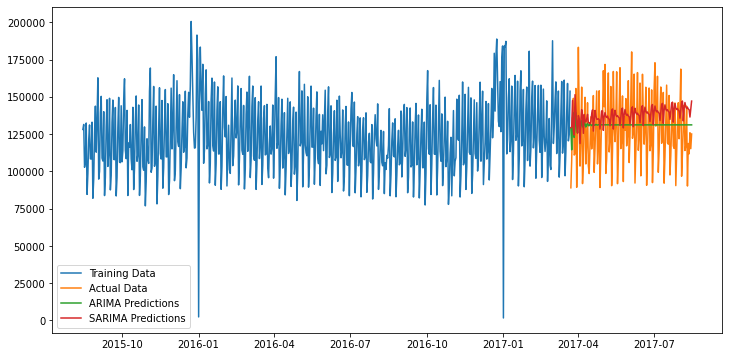

In [55]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, arima_pred, label='ARIMA Predictions')
plt.plot(test.index, sarima_pred, label='SARIMA Predictions')
plt.legend()
plt.show()

In [63]:
df

family,PRODUCE
date,
2015-08-15,128147.17800
2015-08-16,131493.92710
2015-08-17,102769.59890
2015-08-18,106468.22500
2015-08-19,132449.57997
...,...
2017-08-11,118738.14300
2017-08-12,111788.35090
2017-08-13,125923.80240


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
# Extract the target variable (sales for 'PRODUCE' family)
target_column = 'PRODUCE'
ts = df[target_column].values.reshape(-1, 1)


In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
ts_scaled = scaler.fit_transform(ts)


In [ ]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append((seq, label))
    return np.array(sequences)


In [ ]:
# Hyperparameters
seq_length = 10
batch_size = 32
epochs = 50

In [ ]:
# Create sequences
sequences = create_sequences(ts_scaled, seq_length)

# Split into features and labels
X = np.array([seq for seq, _ in sequences])
y = np.array([label for _, label in sequences])

In [ ]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
model.fit(X, y, batch_size=batch_size, epochs=epochs, shuffle=True)

In [ ]:

# Make predictions for the next 365 days
last_sequence = ts_scaled[-seq_length:]
predicted_values = []

for _ in range(365):
    pred = model.predict(last_sequence.reshape(1, seq_length, 1))[0, 0]
    predicted_values.append(pred)
    last_sequence = np.append(last_sequence[1:], pred).reshape(-1, 1)

In [ ]:
# Inverse transform the predictions to the original scale
predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))


In [ ]:
# Create dates for the next 365 days
last_date = df.index[-1]
next_dates = pd.date_range(last_date + pd.DateOffset(1), periods=365)


In [ ]:
# Create a DataFrame with the predicted values and dates
predicted_df = pd.DataFrame({'date': next_dates, 'predicted_sales': predicted_values.flatten()})
predicted_df.set_index('date', inplace=True)


C:\Users\Darshan\AppData\Local\Temp\ipykernel_12132\2241792693.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sequences)


Epoch 1/50
23/23 [==============================] - 3s 11ms/step - loss: 0.2294
Epoch 2/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0310
Epoch 3/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0172
Epoch 4/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0163
Epoch 5/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0162
Epoch 6/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0163
Epoch 7/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0162
Epoch 8/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0166
Epoch 9/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0165
Epoch 10/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0164
Epoch 11/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0161
Epoch 12/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0162
Epoch 13/50
23/23 [==================

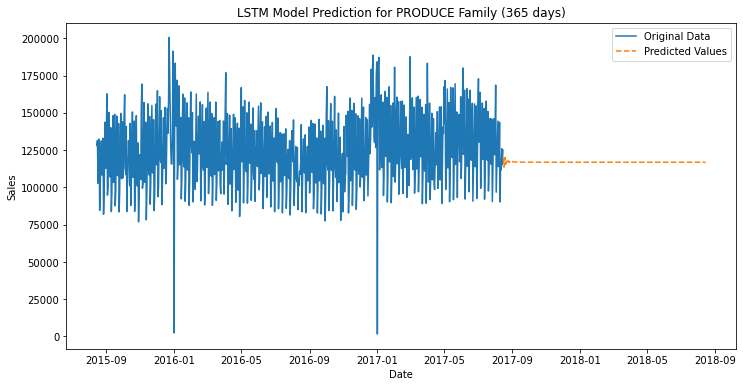

In [66]:
# Plot the original data and the predicted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df[target_column], label='Original Data')
plt.plot(predicted_df.index, predicted_df['predicted_sales'], label='Predicted Values', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('LSTM Model Prediction for PRODUCE Family (365 days)')
plt.legend()
plt.show()













In [67]:
from sklearn.metrics import mean_squared_error

# Extract the actual values for the next 365 days from your dataset
actual_values = df[target_column][-365:].values

# Calculate RMSE
rmse_lstm = np.sqrt(mean_squared_error(actual_values, predicted_values))
print(f'LSTM RMSE: {rmse_lstm:.2f}')


LSTM RMSE: 26949.17


In [68]:
# Set the tolerance for correctness (e.g., ±5%)
tolerance = 0.05

# Calculate the percentage of correct predictions within the tolerance
correct_predictions = np.sum(np.abs(actual_values - predicted_values) / actual_values <= tolerance)
total_predictions = len(actual_values)
accuracy_percentage = (correct_predictions / total_predictions) * 100

print(f'Accuracy (within ±{tolerance*100}%): {accuracy_percentage:.2f}%')


Accuracy (within ±5.0%): 8364.38%


In [69]:
from sklearn.metrics import mean_squared_error

# Assuming 'df' is your original dataset
# Using the 'df' dataset after the Prophet forecast
# Assuming the dataset is already loaded into a DataFrame df

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Extract the target variable (sales for 'PRODUCE' family)
target_column = 'PRODUCE'
ts = df[target_column].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
ts_scaled = scaler.fit_transform(ts)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append((seq, label))
    return np.array(sequences)

# Hyperparameters
seq_length = 10
batch_size = 32
epochs = 50

# Create sequences
sequences = create_sequences(ts_scaled, seq_length)

# Split into features and labels
X = np.array([seq for seq, _ in sequences])
y = np.array([label for _, label in sequences])

# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
model.fit(X, y, batch_size=batch_size, epochs=epochs, shuffle=True)

# Make predictions for the next 30 days
last_sequence = ts_scaled[-seq_length:]
predicted_values = []

for _ in range(30):
    pred = model.predict(last_sequence.reshape(1, seq_length, 1))[0, 0]
    predicted_values.append(pred)
    last_sequence = np.append(last_sequence[1:], pred).reshape(-1, 1)

# Inverse transform the predictions to the original scale
predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))

# Extract the actual values for the next 30 days from your dataset
actual_values = df[target_column][-30:].values

# Calculate RMSE
rmse_lstm = np.sqrt(mean_squared_error(actual_values, predicted_values))
print(f'LSTM RMSE for 30 days: {rmse_lstm:.2f}')


KeyError: "None of ['date'] are in the columns"